In [10]:
# Importing libraries

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Set constants

DIR = os.getcwd()

# Set possible values for the parameters

n = [50, 100, 500, 1000]
version = ["v1", "v2"]
agent_combi = ["mmmm", "mmms", "mmss", "msss"]
agent_types = ["MCTS", "SEMIRANDOM", "RANDOM", "HANDSCORE"]

In [12]:
# Counting wins

PLAYER_MAPPING = {0: "player0", 1: "player1", 2: "player2", 3: "player3"}

def win_rate(data):
    wins = {}
    for agent in agent_types:
        wins[agent] = [0, 0]  # games won, games played

    def add_to_wins(row):
        # select random player for each agent type
        players = {}
        for p in agent_types:
            players[p] = []

        for i in range(4):
            players[row[PLAYER_MAPPING[i]]].append(i)

        chosen = {}
        for key, value in players.items():
            if len(value) != 0:
                chosen[key] = players[key][np.random.randint(len(players[key]))]

        # games played
        for p in chosen.keys():
            wins[p][1] += 1

        # winner
        if not math.isnan(row["winning_player"]):
            winner = int(row["winning_player"])
            for agent, chosen_player in chosen.items():
                if chosen_player == winner:
                    wins[agent][0] += 1

    data.apply(lambda x: add_to_wins(x), axis=1)
    return wins

def print_win_rate(win_dict):
    for agent in agent_types:
        if win_dict[agent][1] != 0:
            print(
                f"{agent} win rate: {round(win_dict[agent][0]/win_dict[agent][1] * 100, 2)}% ({win_dict[agent][0]} of {win_dict[agent][1]} games played)"
            )


def wins_to_df(data, param_values = {}):
    win_dict = win_rate(data)
    df = pd.DataFrame.from_dict(win_dict, orient="index", columns=["wins", "games_played"])
    for param, value in param_values.items():
        df[param] = value
    df = df.rename_axis("agent").reset_index()

    return df

def complete_df():
    df = pd.DataFrame(columns=['agent', 'n', 'wins', 'games_played'])
    for v in version:
        for i in n:
            for j in agent_combi:
                filepath = f"{DIR}/{v}/data/game_history_{j}_{i}.csv"
                to_add_df = wins_to_df(pd.read_csv(filepath), {"version": v, "n": i})
                df = pd.concat([df, to_add_df])
    df = df.loc[df['games_played'] != 0]
    df = df.groupby(['agent', 'n', "version"]).sum().reset_index()
    df['win_rate'] = df['wins'] / df['games_played']
    return df



In [13]:
# Rule based agent performance comparison

win_rate_semi = wins_to_df(pd.read_csv(f"{DIR}/v1/data/game_history_ssss.csv"))
win_rate_random = wins_to_df(pd.read_csv(f"{DIR}/v1/data/game_history_rrrr.csv"))
win_date_handscore = wins_to_df(pd.read_csv(f"{DIR}/v1/data/game_history_hhhh.csv"))
win_date_mcts_50 = wins_to_df(pd.read_csv(f"{DIR}/v1/data/game_history_mmmm_50.csv"), {"n": 50})
win_date_mcts_500 = wins_to_df(pd.read_csv(f"{DIR}/v1/data/game_history_mmmm_500.csv"), {"n": 500})
win_date_mcts_100 = wins_to_df(pd.read_csv(f"{DIR}/v1/data/game_history_mmmm_100.csv"), {"n": 100})
win_date_mcts_1000 = wins_to_df(pd.read_csv(f"{DIR}/v1/data/game_history_mmmm_1000.csv"), {"n": 1000})
win_date_mcts_10000 = wins_to_df(pd.read_csv(f"{DIR}/v1/data/game_history_mmmm_10000.csv"), {"n": 10000})

straight_perf_df = pd.DataFrame(columns=['agent', 'n', 'wins', 'games_played'])
straight_perf_df = pd.concat([straight_perf_df, win_rate_semi, win_rate_random, win_date_handscore, win_date_mcts_50, win_date_mcts_500, win_date_mcts_100, win_date_mcts_1000, win_date_mcts_10000])
straight_perf_df = straight_perf_df.loc[straight_perf_df['games_played'] != 0]
straight_perf_df['win_rate'] = straight_perf_df['wins'] / straight_perf_df['games_played']
straight_perf_df

,agent,n,wins,games_played,win_rate
1,SEMIRANDOM,NaN,1323,10000,0.1323
2,RANDOM,NaN,683,10000,0.0683
3,HANDSCORE,NaN,849,10000,0.0849
0,MCTS,50.0,31,419,0.0739857
0,MCTS,500.0,3,39,0.0769231
0,MCTS,100.0,14,220,0.0636364
0,MCTS,1000.0,1,21,0.047619
0,MCTS,10000.0,0,1,0


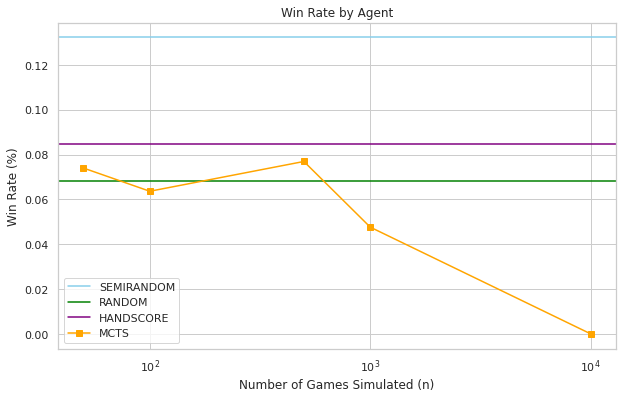

In [14]:
# Performance of agents playing with itself: i.e. MMMM, RRRR, SSSS, HHHH

# Replace NaN in 'n' with a constant for plotting purposes
# We use 10 as it's a round logarithmic number and won't plot on the x-axis (since it's out of bounds)
straight_perf_df['n'].fillna(10, inplace=True)

# Now let's plot the data using seaborn
sns.set_theme(style="whitegrid")

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot lines for SEMIRANDOM, RANDOM, and HANDSCORE
rule_based_agents = {'SEMIRANDOM':"skyblue", 'RANDOM':"green", 'HANDSCORE':"purple"}
for agent, chosen_colour in rule_based_agents.items():
    agent_data = straight_perf_df[straight_perf_df['agent'] == agent]
    plt.axhline(y=agent_data['win_rate'].iloc[0], linestyle='-', label=agent, color = chosen_colour)

# Plot line with markers for MCTS
mcts_data = straight_perf_df[straight_perf_df['agent'] == 'MCTS'].sort_values(by='n')
# sns.lineplot(data=mcts_data, x='n', y='win_rate', marker='o', label='MCTS')
plt.plot(mcts_data['n'], mcts_data['win_rate'], label='MCTS', color='orange', marker='s')


# Add titles and labels
plt.title('Win Rate by Agent')
plt.xlabel('Number of Games Simulated (n)')
plt.ylabel('Win Rate (%)')
plt.xscale('log')  # Log scale for better visualization
plt.legend()

# Show the plot
plt.show()

In [15]:
mcts_semirandom_df = complete_df()

mcts_semirandom_df.head()

,agent,n,version,wins,games_played,win_rate
0,MCTS,50,v1,182,3208,0.056733
1,MCTS,50,v2,176,2771,0.063515
2,MCTS,100,v1,90,1694,0.053129
3,MCTS,100,v2,81,1432,0.056564
4,MCTS,500,v1,24,300,0.080000


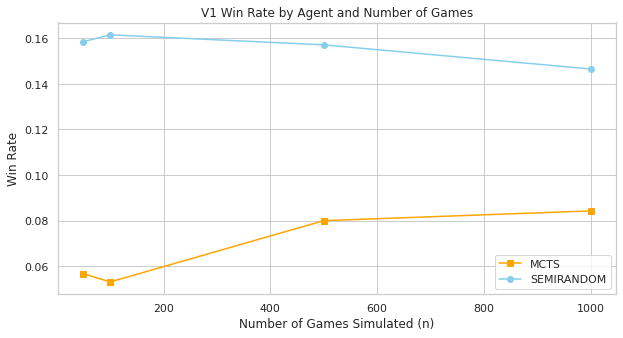

In [16]:
# V1 - win rate by agent and number of games
v1_df = mcts_semirandom_df.loc[mcts_semirandom_df['version'] == "v1"]
mcts_data = v1_df[v1_df['agent'] == 'MCTS']
semirandom_data = v1_df[v1_df['agent'] == 'SEMIRANDOM']

# Let's plot the data
plt.figure(figsize=(10, 5))

# Plot MCTS agent data as a line with markers
plt.plot(mcts_data['n'], mcts_data['win_rate'], label='MCTS', color='orange', marker='s')

# Plot SEMIRANDOM agent data as a line with markers
plt.plot(semirandom_data['n'], semirandom_data['win_rate'], label='SEMIRANDOM', color='skyblue', marker='o')

# Add titles and labels
plt.title('V1 Win Rate by Agent and Number of Games')
plt.xlabel('Number of Games Simulated (n)')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

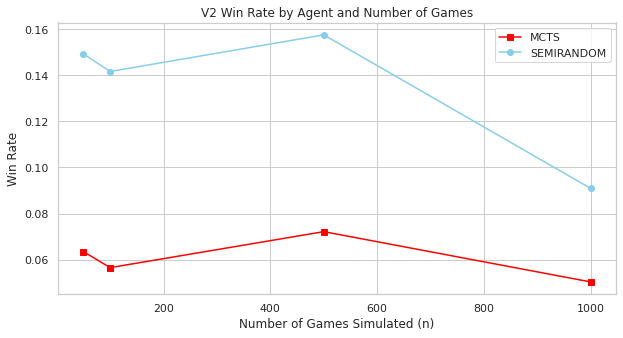

In [17]:
# V2 - win rate by agent and number of games
v2_df = mcts_semirandom_df.loc[mcts_semirandom_df['version'] == "v2"]
mcts_data = v2_df[v2_df['agent'] == 'MCTS']
semirandom_data = v2_df[v2_df['agent'] == 'SEMIRANDOM']

# Let's plot the data
plt.figure(figsize=(10, 5))

# Plot MCTS agent data as a line with markers
plt.plot(mcts_data['n'], mcts_data['win_rate'], label='MCTS', color='red', marker='s')

# Plot SEMIRANDOM agent data as a line with markers
plt.plot(semirandom_data['n'], semirandom_data['win_rate'], label='SEMIRANDOM', color='skyblue', marker='o')

# Add titles and labels
plt.title('V2 Win Rate by Agent and Number of Games')
plt.xlabel('Number of Games Simulated (n)')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

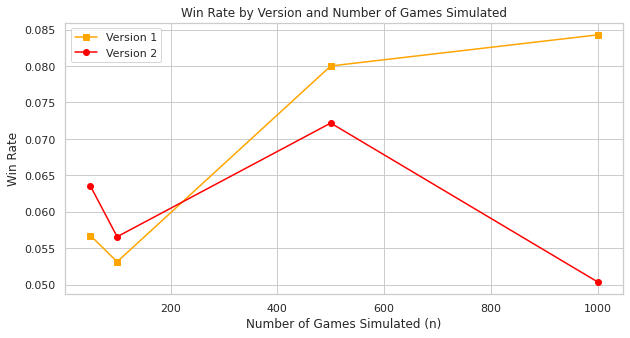

In [18]:
# Win rate by versions

v1_mcts = mcts_semirandom_df.loc[(mcts_semirandom_df['agent'] == "MCTS") & (mcts_semirandom_df['version'] == "v1")]
v2_mcts = mcts_semirandom_df.loc[(mcts_semirandom_df['agent'] == "MCTS") & (mcts_semirandom_df['version'] == "v2")]

# Let's plot the data
plt.figure(figsize=(10, 5))

# Plot MCTS agent data as a line with markers
plt.plot(v1_mcts['n'], v1_mcts['win_rate'], label='Version 1', color='orange', marker='s')

# Plot SEMIRANDOM agent data as a line with markers
plt.plot(v2_mcts['n'], v2_mcts['win_rate'], label='Version 2', color='red', marker='o')

# Add titles and labels
plt.title('Win Rate by Version and Number of Games Simulated')
plt.xlabel('Number of Games Simulated (n)')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()